# Cubs lineup analysis

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

A lookup at the lineups selected by Chicago Cubs Manager Joe Maddon during the 2018 baseball season.

In [1]:
import pandas as pd
import altair as alt
import altair_latimes as lat

In [2]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [3]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [4]:
pd.set_option('display.max_colwidth', -1)

In [5]:
df = pd.read_csv("./input/CHC_batting_orders_all.csv").set_index("number")

### How many distinct lineups have been used?

In [6]:
def create_id(row):
    return '-'.join(row[[
        'one',
        'two',
        'three',
        'four',
        'five',
        'six',
        'seven',
        'eight',
        'nine'
    ]])

In [7]:
df['id'] = df.apply(create_id, axis=1)

### By year

In [8]:
lineups_by_year = df.groupby(['year', 'id']).size().reset_index(name='lineups').groupby(['year']).size().reset_index(name="lineups")

In [9]:
lineups_by_year['manager'] = lineups_by_year.year.apply(
    lambda x: 'Joe Maddon' if x >= 2015 else 'Somebody else'
)

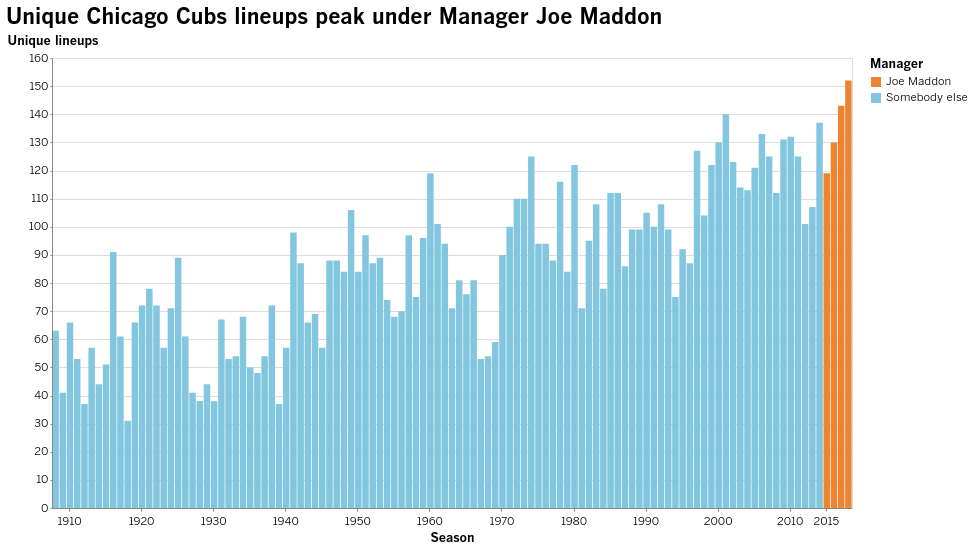

In [10]:
alt.Chart(lineups_by_year).mark_bar().encode(
    x=alt.X(
        "year:O",
        title="Season",
        axis=alt.Axis(values=[
            1910,
            1920,
            1930,
            1940,
            1950,
            1960,
            1970,
            1980,
            1990,
            2000,
            2010,
            2015
        ])
    ),
    y=alt.Y(
        "lineups:Q",
        title="Unique lineups"
    ),
    color=alt.Color(
        "manager:N",
        title="Manager",
        scale=alt.Scale(
            domain=['Joe Maddon', 'Somebody else'],
            range=[lat.palette['highlight'], lat.palette['default']]
        )
    )
).properties(
    width=800,
    title="Unique Chicago Cubs lineups peak under Manager Joe Maddon"
)

### Pitchers batting 9th

In [11]:
f"{(len(df[df.nine == 'pitcher']) / len(df.nine))*100:.01f}%"

'97.5%'

In [12]:
df['pitcher_batting_ninth'] = df['nine'] == 'pitcher'

In [13]:
pitcher_ninth_by_year = df.groupby(["year", "pitcher_batting_ninth"]).size().rename("lineups").reset_index().pivot(
    index="year",
    columns="pitcher_batting_ninth",
    values="lineups"
).fillna(0)

In [14]:
pitcher_ninth_by_year['total'] = pitcher_ninth_by_year[False] + pitcher_ninth_by_year[True]

In [15]:
pitcher_ninth_by_year['percent'] = pitcher_ninth_by_year[True] / pitcher_ninth_by_year['total']

In [16]:
pitcher_ninth_by_year.sort_values(False, ascending=False).head(10)

pitcher_batting_ninth,False,True,total,percent
year,,,,
2015,150.0,12.0,162.0,0.074074
2017,65.0,97.0,162.0,0.598765
2018,64.0,99.0,163.0,0.607362
2016,19.0,143.0,162.0,0.882716
2014,10.0,152.0,162.0,0.938272
2013,10.0,152.0,162.0,0.938272
2008,9.0,152.0,161.0,0.944099
2003,9.0,153.0,162.0,0.944444
2006,9.0,153.0,162.0,0.944444


In [17]:
stacked_pitcher_ninth_by_year = pitcher_ninth_by_year.rename(columns={
    True: "Yes",
    False: "No"
})[["Yes", "No"]].stack().reset_index().rename(columns={
    "year": "Year",
    "pitcher_batting_ninth": "Pitcher batting 9th",
    0: "Lineups"
})

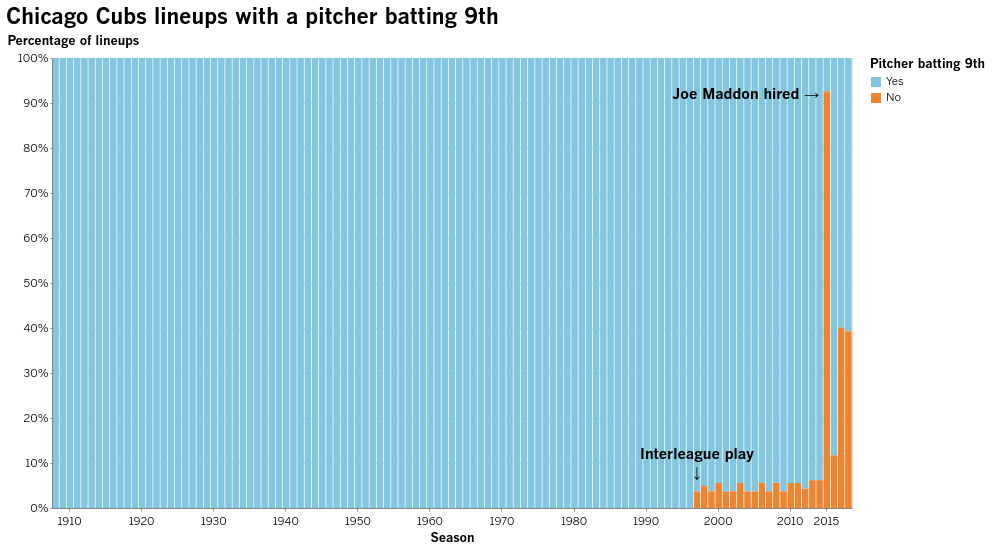

In [18]:
bars = alt.Chart(stacked_pitcher_ninth_by_year).mark_bar().encode(
    x=alt.X(
        "Year:O",
        title="Season",
        axis=alt.Axis(values=list(range(1910, 2020, 10)) + [2015])
    ),
    y=alt.Y(
        "sum(Lineups):Q",
        title="Percentage of lineups",
        stack='normalize',
        axis=alt.Axis(format='%', title='percentage')
    ),
    color=alt.Color(
        "Pitcher batting 9th:N",
        scale=alt.Scale(
            domain=['Yes', 'No'],
            range=[lat.palette['default'], lat.palette['highlight']]
        )
    ),
    order=alt.Order(
      'Pitcher batting 9th',
      sort='ascending'
    )
)

a = {'x': [1997, 1997], 'y': [0.07, 0.11], 'textof': ['↓', "Interleague play"]}
text = alt.Chart(pd.DataFrame(a)).mark_text(fontSize=15, font="Benton Gothic Bold").encode(
    x='x:O',
    y='y:Q',
    text='textof:N'
)

a2 = {'x': [2010], 'y': [0.91], 'textof': ["Joe Maddon hired →"]}
text2 = alt.Chart(pd.DataFrame(a2)).mark_text(fontSize=15, dx=-45, font="Benton Gothic Bold").encode(
    x='x:O',
    y='y:Q',
    text='textof:N'
)

(bars + text + text2).properties(
    width=800,
    title="Chicago Cubs lineups with a pitcher batting 9th"
)

In [53]:
df.nine.value_counts().reset_index().head(10)

,index,nine
0,pitcher,16993
1,Russell,135
2,Almora,33
3,Herrera,21
4,Jay,21
5,Happ,18
6,Stella,15
7,Bote,15
8,Baez,15
9,Blanco,13


### 2015

In [45]:
df_2015 = df[df.year == 2015]

In [48]:
df_2015.nine.value_counts().reset_index()

,index,nine
0,Russell,116
1,Herrera,21
2,pitcher,12
3,Stella,9
4,Coghlan,2
5,Alcantara,2


In [49]:
df_maddon = df[df.year >= 2015]

In [54]:
df_maddon.nine.value_counts().reset_index().head(10)

,index,nine
0,pitcher,351
1,Russell,135
2,Almora,33
3,Herrera,21
4,Jay,21
5,Happ,18
6,Baez,15
7,Bote,15
8,Stella,15
9,Schwarber,6


### 1969

In [19]:
df_1969 = df[df.year == 1969]

In [20]:
df_1969.id.describe()

count     163                                                                  
unique    59                                                                   
top       Kessinger-Beckert-Williams-Santo-Banks-Hundley-Spangler-Young-pitcher
freq      18                                                                   
Name: id, dtype: object

In [21]:
top_lineups = df_1969.groupby("id").size().rename("games").reset_index().sort_values("games", ascending=False)

In [22]:
top_lineups[top_lineups.games > 1]

,id,games
22,Kessinger-Beckert-Williams-Santo-Banks-Hundley-Spangler-Young-pitcher,18
19,Kessinger-Beckert-Williams-Santo-Banks-Hundley-Hickman-Young-pitcher,17
24,Kessinger-Beckert-Williams-Santo-Banks-Smith-Hundley-Qualls-pitcher,11
14,Kessinger-Beckert-Williams-Santo-Banks-Hickman-Hundley-Young-pitcher,11
11,Kessinger-Beckert-Williams-Santo-Banks-Hickman-Hundley-Gamble-pitcher,9
21,Kessinger-Beckert-Williams-Santo-Banks-Hundley-Spangler-Phillips-pitcher,7
51,Kessinger-Popovich-Williams-Santo-Banks-Smith-Hundley-Young-pitcher,6
49,Kessinger-Popovich-Williams-Santo-Banks-Hundley-Spangler-Young-pitcher,5
17,Kessinger-Beckert-Williams-Santo-Banks-Hundley-Hickman-Phillips-pitcher,5
25,Kessinger-Beckert-Williams-Santo-Banks-Smith-Hundley-Young-pitcher,5


### 2018

In [23]:
df_2018 = df[df.year == 2018]

In [24]:
df_2018.head()

,year,one,two,three,four,five,six,seven,eight,nine,id,pitcher_batting_ninth
number,,,,,,,,,,,,
1,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,Baez,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher,True
2,2018,Almora,Bryant,Rizzo,Contreras,Schwarber,Russell,Zobrist,Baez,pitcher,Almora-Bryant-Rizzo-Contreras-Schwarber-Russell-Zobrist-Baez-pitcher,True
3,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Zobrist,Heyward,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Zobrist-Heyward-pitcher,True
4,2018,Almora,Bryant,Rizzo,Russell,Schwarber,Caratini,Heyward,Baez,pitcher,Almora-Bryant-Rizzo-Russell-Schwarber-Caratini-Heyward-Baez-pitcher,True
5,2018,Happ,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,Baez,pitcher,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher,True


In [25]:
df_2018.id.describe()

count     163                                                                 
unique    152                                                                 
top       Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher
freq      5                                                                   
Name: id, dtype: object

In [26]:
top_lineups = df_2018.groupby("id").size().rename("games").reset_index().sort_values("games", ascending=False)

In [27]:
top_lineups[top_lineups.games > 1]

,id,games
2,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,5
25,Almora-Heyward-Baez-Rizzo-Contreras-Schwarber-Happ-Russell-pitcher,2
72,Murphy-Baez-Rizzo-Zobrist-Heyward-Contreras-Schwarber-pitcher-Bote,2
144,Zobrist-Heyward-Bryant-Rizzo-Contreras-Schwarber-Baez-Almora-pitcher,2
10,Almora-Baez-Rizzo-Contreras-Stella-Schwarber-Russell-Heyward-Happ,2
53,Happ-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-Baez-pitcher,2
106,Rizzo-Bryant-Heyward-Baez-Contreras-Schwarber-Almora-Russell-pitcher,2
15,Almora-Bryant-Rizzo-Baez-Zobrist-Contreras-Bote-pitcher-Russell,2


### Has the lineup in Game 163 against the Brewers ever been used before?

<img src="input/game163.jpg">

In [28]:
game163 = 'Murphy-Zobrist-Baez-Rizzo-Bryant-Schwarber-Heyward-pitcher-Contreras'

In [29]:
df[df.id==game163]

,year,one,two,three,four,five,six,seven,eight,nine,id,pitcher_batting_ninth
number,,,,,,,,,,,,
163,2018,Murphy,Zobrist,Baez,Rizzo,Bryant,Schwarber,Heyward,pitcher,Contreras,Murphy-Zobrist-Baez-Rizzo-Bryant-Schwarber-Heyward-pitcher-Contreras,False


### Has the lineup in the Wild Card Game ever been used before?

<img src="input/wild-card-lineup.jpg">

In [30]:
wildcard = "Zobrist-Bryant-Rizzo-Baez-Almora-Murphy-Contreras-Bote-pitcher"

In [31]:
df[df.id==wildcard]

,year,one,two,three,four,five,six,seven,eight,nine,id,pitcher_batting_ninth
number,,,,,,,,,,,,


### When was the most frequent lineup used?

In [32]:
df[df.id == 'Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher']

,year,one,two,three,four,five,six,seven,eight,nine,id,pitcher_batting_ninth
number,,,,,,,,,,,,
16,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,True
17,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,True
25,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,True
49,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,True
52,2018,Almora,Baez,Bryant,Rizzo,Contreras,Schwarber,Russell,Heyward,pitcher,Almora-Baez-Bryant-Rizzo-Contreras-Schwarber-Russell-Heyward-pitcher,True


### How many times has the pitcher batted ninth?

In [33]:
len(df_2018[df_2018.nine == 'pitcher'])

99

In [34]:
len(df_2018[df_2018.eight == 'pitcher'])

54

In [35]:
df_2018.nine.describe()

count     163    
unique    8      
top       pitcher
freq      99     
Name: nine, dtype: object

In [36]:
df_2018.nine.value_counts()

pitcher      99
Happ         18
Russell      16
Bote         15
Almora       7 
Caratini     4 
Stella       3 
Contreras    1 
Name: nine, dtype: int64

### Who are the most frequent batters at the other positions?

In [37]:
df_2018.eight.value_counts()

pitcher      54
Heyward      25
Happ         21
Russell      20
Baez         12
Gimenez      8 
Caratini     6 
Schwarber    4 
Contreras    4 
Bote         4 
Almora       3 
Stella       2 
Name: eight, dtype: int64

In [38]:
df_2018.seven.value_counts()

Russell      42
Contreras    27
Happ         19
Baez         15
Caratini     15
Heyward      13
Schwarber    9 
Almora       8 
Bote         8 
Zobrist      5 
Gimenez      1 
Stella       1 
Name: seven, dtype: int64

In [39]:
df_2018.six.value_counts()

Schwarber    71
Contreras    16
Russell      14
Happ         13
Caratini     11
Almora       8 
Bote         8 
Baez         7 
Zobrist      6 
Bryant       4 
Heyward      3 
Stella       2 
Name: six, dtype: int64

In [40]:
df_2018.five.value_counts()

Contreras    43
Schwarber    27
Baez         17
Happ         16
Russell      12
Zobrist      11
Almora       8 
Heyward      7 
Stella       7 
Bryant       6 
Bote         5 
Caratini     4 
Name: five, dtype: int64

In [41]:
df_2018.four.value_counts()

Rizzo        67
Baez         31
Contreras    29
Zobrist      17
Russell      5 
Heyward      5 
Bryant       3 
Bote         3 
Murphy       2 
Schwarber    1 
Name: four, dtype: int64

In [42]:
df_2018.three.value_counts()

Rizzo        49
Bryant       36
Zobrist      23
Baez         22
Heyward      21
Bote         4 
Schwarber    2 
Contreras    2 
Almora       2 
Murphy       1 
Stella       1 
Name: three, dtype: int64

In [43]:
df_2018.two.value_counts()

Bryant       43
Baez         37
Heyward      37
Zobrist      19
Almora       12
Schwarber    6 
Stella       5 
Happ         2 
Russell      1 
Rizzo        1 
Name: two, dtype: int64

In [44]:
df_2018.one.value_counts()

Almora       46
Rizzo        31
Murphy       30
Zobrist      27
Happ         13
Bryant       7 
Baez         4 
Stella       3 
Schwarber    1 
Contreras    1 
Name: one, dtype: int64